# Pipeline
 - ## Preprocesamiento de Imagen
    - Redimensionar imagen (640x480)
 - ## Extraer Mapa de profundidad
    - Con el modelo DepthAnything v2
    - Guardar mapa como .npy file
 - ## Generar Nube de Puntos:
    - Con la matriz de la profundidad
    - Los colores de la imagen original
    - Con intrinsics genéricos
    - Generar la nube de puntos
 - ## Postprocesamiento
    - Remover outliers
    - Guardar como .ply file
 - ## Preproc de registración
    - Downsampling con voxels
    - Estimación de normales
 - ## Registración: Global Registration using Fast Point Feature Histograms (FPFH) 
 - ## Registración: Colored Iterative Closest Point (ICP)
   

### Converting Images to Point Cloud
This notebook demonstrates how to convert images to point clouds using the [Open3D](http://www.open3d.org/) library. The images are first converted to depth maps using a pre-trained model, and then the depth maps are converted to point clouds. The point clouds are then visualized using Open3D.

In [28]:
import os
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np 
import copy
from numpy import asarray
from PIL import Image
from transformers import pipeline
import cv2

#### Import data
The data is imported from the `input` directory. These images are transformed to depth maps (saved in the `output\depth` directory) and then to point clouds (saved in the `output\pcd` directory).

In [29]:
data_set_name = 'house'
input_path = os.path.join(os.path.normpath("Data/input"), data_set_name)
output_dir = os.path.join(os.path.normpath("Data/output"), data_set_name)
output_dir_depth = os.path.join(output_dir,"depth")
output_dir_pcd = os.path.join(output_dir,"pcd")

os.makedirs(output_dir_depth, exist_ok=True)
os.makedirs(output_dir_pcd, exist_ok=True)

In [30]:
dir_list = os.listdir(input_path)
original_paths = []
depth_map_pahts = []
for filename in dir_list:
    if filename != None:
        image_path = os.path.join(input_path, filename)
        output_path = os.path.join(output_dir_depth, filename.split('.')[0] + '_depth.npy')
        original_paths.append(image_path)
        depth_map_pahts.append(output_path)
df_paths = pd.DataFrame({'Original': original_paths, 'DepthMap': depth_map_pahts})

#### Preprocessing images
The images are resized to 640x480 pixels before being converted to depth maps.

In [31]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((640, 480))
    image.save(image_path)

In [32]:
var = df_paths["Original"].apply(preprocess_image)

#### Transform images to depth maps
Function to convert images to depth maps:

In [33]:
def img_to_depth_map(depth_estimation_pipeline, image_path, output_path):
    image = Image.open(image_path)

    depth_map = depth_estimation_pipeline(image)
    depth_map_tensor = depth_map['predicted_depth']
    
    dm = depth_map_tensor[0].numpy()
    np.save(output_path, dm)

Load depth model

In [34]:
# depth_estimation_pipeline = pipeline("depth-estimation", model="vinvino02/glpn-nyu")
# depth_estimation_pipeline = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
depth_estimation_pipeline = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")

C:\Users\yraul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [35]:
var = df_paths.apply(lambda row: img_to_depth_map(depth_estimation_pipeline, row["Original"], row['DepthMap']), axis=1)

#### Visualize Depth Map Results

In [36]:
def to_8bit(dm):
    max_pixel_value = dm.max()
    dm = dm / max_pixel_value * 255
    dm = dm.astype('uint8')
    return dm

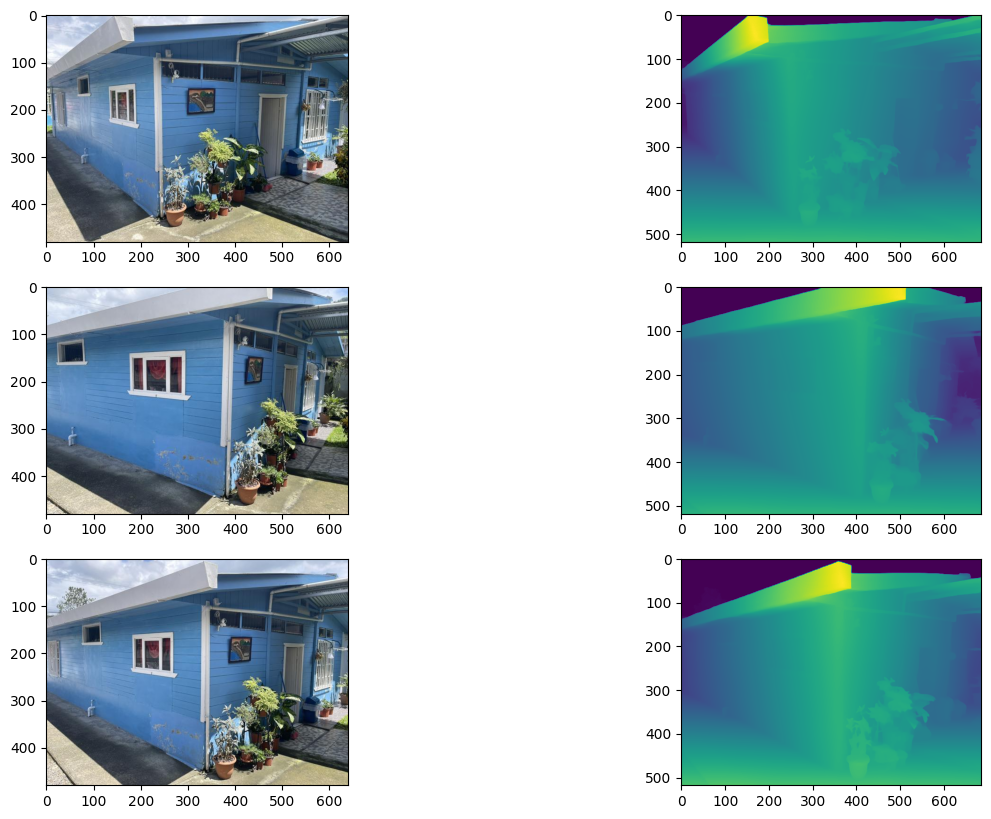

In [37]:
df_sample = df_paths.sample(3)
x, y = df_sample.shape
fig, axs = plt.subplots(x, 2, figsize=(15, 10))
for i, (index, row) in enumerate(df_sample.iterrows()):
    original_img = imread(row['Original'])
    depth_map = np.load(row["DepthMap"], allow_pickle=True)
    axs[i, 0].imshow(to_8bit(original_img))
    axs[i, 1].imshow(to_8bit(depth_map))

#### Transform Depth Maps into Point Clouds

Build the path to the point cloud directory for every image in the `output\pcd` directory.

In [38]:
def build_pc_output_path(image_path):
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]
    return os.path.join(output_dir_pcd, image_name + '.ply')

df_paths["PointCloud"] = df_paths["Original"].apply(build_pc_output_path)

In [39]:
def get_intrinsics(H,W,fov=55):
    f = 0.5 * W / np.tan(0.5 * fov * np.pi / 180)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx], 
                     [0, f, cy], 
                     [0, 0, 1]])

Function to convert depth maps to point clouds.
The camera parameteres doesn't correspond to the real camera parameters, but they are used to generate the point cloud.

In [40]:
def pixel_to_point(dm, camera_intrinsics):

    height, width = dm.shape
    if camera_intrinsics is None:
        camera_intrinsics = get_intrinsics(height, width, fov=55)
    
    fx,fy = camera_intrinsics[0,0], camera_intrinsics[1,1]
    cx,cy = camera_intrinsics[0,2], camera_intrinsics[1,2]
    
    x = np.linspace(0, width-1, width)
    y = np.linspace(0, height-1, height)
    u, v = np.meshgrid(x, y)

    x_over_z = (u - cx) / fx
    y_over_z = (v - cy) / fy

    z = dm / np.sqrt(1 + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return x,y,z

def make_pcd(dm, color_image, camera_intrinsics=None, scale_ratio=100):

    height, width = dm.shape
    if camera_intrinsics is None:
        camera_intrinsics = get_intrinsics(height, width, fov=55)
    color_image = cv2.resize(color_image, (width, height))

    depth_image = np.maximum(dm, 1e-5) #dm should not have a zero value

    depth_image = scale_ratio / depth_image
    x,y,z = pixel_to_point(depth_image, camera_intrinsics)
    point_image = np.stack((x,y,z), axis=-1)
    

    cloud = o3d.geometry.PointCloud()
    # cloud.points = o3d.utility.Vector3dVector(point_image.reshape(-1,3))
    # cloud.colors = o3d.utility.Vector3dVector(color_image.reshape(-1,3)/255)

    # masking for outdoor skyes
    mask = point_image[:,:,2] < 1e2
    cloud.points = o3d.utility.Vector3dVector(point_image[mask].reshape(-1,3))
    cloud.colors = o3d.utility.Vector3dVector(color_image[mask].reshape(-1,3)/255)

    return cloud

def post_processing(pcd_raw):
    cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=2)
    return pcd_raw.select_by_index(ind)

In [41]:
def depth_to_pcd(image_path, dm_path, output_path):
    image = np.array(Image.open(image_path))
    dm = np.load(dm_path, allow_pickle=True)

    pcd_raw = make_pcd(dm, image)
    pcd = post_processing(pcd_raw)
    o3d.io.write_point_cloud(output_path, pcd)

Transform the depth maps to point clouds and save them in the `point_cloud` directory.

In [42]:
y = df_paths.apply(lambda row: depth_to_pcd(row["Original"],row["DepthMap"], row["PointCloud"]), axis=1)

#### Visualize Sample Point Clouds

We take a random sample and visualize the point clouds.

In [43]:
pcd_path = df_paths.sample(1)["PointCloud"].values[0]    
print(pcd_path)
pcd = o3d.io.read_point_cloud(pcd_path)
o3d.visualization.draw_geometries([pcd])

Data\output\house\pcd\IMG_2633.ply


In [44]:
# from mpl_toolkits.mplot3d import Axes3D


# fig, (ax1) = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(12, 6))

# points = np.asarray(pcd.points)
# x, y , z = points[:, 0], points[:, 1], points[:, 2]
# colors = np.asarray(pcd.colors)

# # Graficar la nube de puntos
# ax1.scatter(x, y, -z, c=colors, s=0.1)
# ax1.view_init(elev=-70, azim=-90) #elevacion y rotacion
# # Configurar etiquetas
# ax1.set_xlabel('Eje X')
# ax1.set_ylabel('Eje Y')
# ax1.set_zlabel('Eje Z')
# ax1.set_title('Filtered Point Cloud')